In [1]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from skimage.color import gray2rgb, rgb2gray, label2rgb

In [3]:
from keras.datasets import mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

Using TensorFlow backend.


In [4]:
train_x.shape

(60000, 28, 28)

In [5]:
image = gray2rgb(train_x[0].reshape(28,28))

In [6]:
train_y.shape

(60000,)

In [7]:
import matplotlib.pyplot as plt
import numpy as np

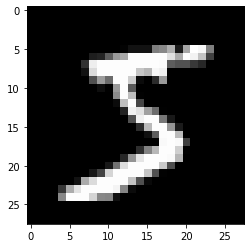

In [8]:
plt.imshow(image)

In [9]:
train_y_new = []

for i in train_y:
  l =[0]*10
  l[i] = 1
  train_y_new.append(l)

In [10]:
train_y = np.array(train_y_new)

In [11]:
train_y.shape

(60000, 10)

In [12]:
test_y_new = []

for i in test_y:
  l =[0]*10
  l[i] = 1
  test_y_new.append(l)

In [13]:
test_y = np.array(test_y_new)

In [14]:
test_y.shape

(10000, 10)

In [15]:
train_x = np.stack([gray2rgb(iimg) for iimg in train_x],0)
test_x = np.stack([gray2rgb(iimg) for iimg in test_x],0)

In [16]:
train_x.shape

(60000, 28, 28, 3)

In [17]:
batch_size = 128
filter_size = 3

In [18]:
x = tf.placeholder(tf.float32,(None, 28,28,3))

In [19]:
y = tf.placeholder(tf.float32,(None,10))
result = tf.Variable(tf.random_normal([10]))

Let the model have three Convolutional Layers

The first layer will have 16 3X3 filters.
The second layer will have 32 3X3 filters.
The third layer will have 64 3X3 filters.

Each layer will have a corresponding bias term as well.

At the end of each layer will have a max pooling layer performing the pooling operation,The pool will be done by a 2X2 filter.

then flatten the output from the last convolution layer to feed it as the input to the fully connected layer.

In [20]:
#conv layer 1 : input image of dimension 28 X 28 X 3.
#The third dimension of the image is the same to be used for the third dimension of the weights
#The conv layer 1 gives out 16 activation maps.
conv1_weight = tf.Variable(tf.truncated_normal([filter_size,filter_size,3,16],stddev=0.1))
conv1_bias = tf.Variable(tf.truncated_normal([16],stddev = 0.1))

#conv layer 2 : input is 16 activation maps from conv layer 1.
#The conv layer 2 gives out 32 activation maps.
conv2_weight = tf.Variable(tf.truncated_normal([filter_size,filter_size,16,32],stddev = 0.1))
conv2_bias = tf.Variable(tf.truncated_normal([32],stddev = 0.1))

#conv layer 3 : input is 32 activation maps from conv layer 2.
#The conv layer 3 gives out 64 activation maps.
conv3_weight = tf.Variable(tf.truncated_normal([filter_size,filter_size,32,64],stddev = 0.1))
conv3_bias = tf.Variable(tf.truncated_normal([64],stddev=0.1))

In [21]:
#At the end of these convolution layers have 4 X 4 X 1 activation maps and 64 of those.
#We need to flatten these

flatten_weight = tf.Variable(tf.truncated_normal([4*4*64,64],stddev =0.1))
flatten_bias = tf.Variable(tf.truncated_normal([64],stddev = 0.1))

In [22]:
#Finally the output layer

output_weight = tf.Variable(tf.truncated_normal([64,10],stddev = 0.1))
output_bias = tf.Variable(tf.truncated_normal([10],stddev = 0.1))

In [23]:
#Now need to define a wrapper around the tensoflow conv2d function to return the conv layer output
#It takes 3 arguments 
#    1.The input -> x
#    2.The weights -> w
#    3.The bias -> b
#use Relu as the activation function

#take the stride as 1
stride = 1

def convolution_2d(x, w, b):
  x = tf.nn.conv2d(x, w, strides=[1, stride, stride, 1], padding='SAME')
  
  z = tf.nn.bias_add(x,b)
  
  op = tf.nn.relu(z)
  
  return op

In [24]:
#Now need to define a wrapper around the tensoflow maxpool2d function to return the pooled output
#It takes 2 arguments 
#    1.The input -> x
#    2.The kernel size -> k

#take the kernel size as 2
kernel_size = 2

def maxpool_2d(x):
  op = tf.nn.max_pool(x, ksize = [1,kernel_size,kernel_size,1], strides = [1,kernel_size,kernel_size,1], padding = 'SAME')
  
  return op

In [25]:
#The function for the fully connected layer
#It takes 3 arguments 
#    1.The input -> x
#    2.The weights -> w
#    3.The bias -> b
#use Relu as the activation function

def fully_connected_layer(x,w,b):
  z = tf.matmul(x,w)
  z = tf.add(z,b)
  
  op = tf.nn.relu(z)
  
  return op

In [26]:
#Output layer
#It takes 3 arguments 
#    1.The input -> x
#    2.The weights -> w
#    3.The bias -> b

def output_layer(x,w,b):
  z = tf.matmul(x,w)
  z = tf.add(z,b)
  return z


In [27]:
#Now that have our wrappers ready, we need to create the model

def cnn_model(x):
  
  #creating the first layer
  conv1 = convolution_2d(x,conv1_weight,conv1_bias)
  conv1 = maxpool_2d(conv1)
  
  #creating the second layer
  conv2 = convolution_2d(conv1,conv2_weight,conv2_bias)
  conv2 = maxpool_2d(conv2)
  
  #creating the third layer
  conv3 = convolution_2d(conv2,conv3_weight,conv3_bias)
  conv3 = maxpool_2d(conv3)
  
  #need to reshape the conv3 output to fit the fully connected layer
  shape_fully_connected = flatten_weight.get_shape().as_list()[0]
  
  fully_connected = tf.reshape(conv3,[-1,shape_fully_connected])
  fully_connected_output = fully_connected_layer(fully_connected, flatten_weight, flatten_bias)
  
  #Output Layer for the class prediction
  output = output_layer(fully_connected_output, output_weight, output_bias)
  
  return output

In [28]:
#now need to write the loss function for the model

#learning rate
learning_rate = 0.001

prediction = cnn_model(x)

#using cross entropy loss and softmax activation
cost_function = tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y)

#take the mean of all the samples in the batch
cost = tf.reduce_mean(cost_function)

#Using Adam Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
optimizer = optimizer.minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [29]:
#check for the correctness of the prediction

correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))

#calculate over the entire batch

accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [30]:
#initialize weights and biases

initializer = tf.global_variables_initializer()

In [31]:
train_x.shape

(60000, 28, 28, 3)

Text(0.5, 1.0, 'Output Class is : [0 0 0 0 1 0 0 0 0 0]')

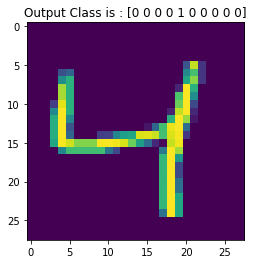

In [32]:
train1 = train_x[2]

train1.shape
train1 = rgb2gray(train1)
output_label_new  = train_y[2]
plt.imshow(train1)
plt.title("Output Class is : "+str(output_label_new))

In [33]:
number_of_epochs = 50
number_of_batches = len(train_x)//batch_size

In [34]:
sess = tf.Session()

#initialize all the global variables
sess.run(initializer)

In [35]:
#creating the arrays to record the loss and accuracy
training_loss = []
training_accuracy = []

validation_losses = []
validation_accuracies = []

summary_writer = tf.summary.FileWriter('./Output', sess.graph)

#loop over all the epochs

for i in range(number_of_epochs):

  #for each batch
  train_loss = 0
  train_accuracy = 0
  for batch in range(number_of_batches):

    #need to obtain corresponding x and y for the batch from the train data

    lower_limit = batch*batch_size
    upper_limit = min((batch+1)*batch_size,len(train_x))

    batch_x = train_x[lower_limit:upper_limit]
    batch_y = train_y[lower_limit:upper_limit]

    #Run the optimizer and
    #Calculate the loss and the accuracy
    _, l_ ,acc_ = sess.run([optimizer, cost, accuracy],feed_dict={x: batch_x, y: batch_y})
    train_loss += l_
    train_accuracy += acc_

  train_loss /= number_of_batches
  train_accuracy /= number_of_batches


  #For the validation data
  validation_loss, validation_accuracy = sess.run([cost,accuracy],feed_dict={x: test_x, y: test_y})

  print("Epoch: ",str(i)," : TrainLoss: ",str(train_loss)," TrainAccuracy: ",str(train_accuracy), " ValidLoss: ",str(validation_loss)," ValidAccuracy : ",str(validation_accuracy))


  training_loss.append(train_loss)
  training_accuracy.append(train_accuracy)

  validation_losses.append(validation_loss)
  validation_accuracies.append(validation_accuracy)

  summary_writer.close() 

Epoch:  0  : TrainLoss:  1.4358148152589734  TrainAccuracy:  0.848808092948718  ValidLoss:  0.21133311  ValidAccuracy :  0.9435
Epoch:  1  : TrainLoss:  0.16217782027008507  TrainAccuracy:  0.9546107104700855  ValidLoss:  0.1265278  ValidAccuracy :  0.9634
Epoch:  2  : TrainLoss:  0.09307295095143664  TrainAccuracy:  0.9729567307692307  ValidLoss:  0.09527994  ValidAccuracy :  0.9719
Epoch:  3  : TrainLoss:  0.06332653888497371  TrainAccuracy:  0.9810196314102564  ValidLoss:  0.10328462  ValidAccuracy :  0.9725
Epoch:  4  : TrainLoss:  0.047767387931662984  TrainAccuracy:  0.9855435363247863  ValidLoss:  0.07972565  ValidAccuracy :  0.9773
Epoch:  5  : TrainLoss:  0.03865348762835318  TrainAccuracy:  0.9877136752136753  ValidLoss:  0.07221011  ValidAccuracy :  0.981
Epoch:  6  : TrainLoss:  0.03258555096849743  TrainAccuracy:  0.9889489850427351  ValidLoss:  0.09028023  ValidAccuracy :  0.9774
Epoch:  7  : TrainLoss:  0.03393255986085358  TrainAccuracy:  0.9888488247863247  ValidLoss: 

In [36]:
test_x.shape

(10000, 28, 28, 3)

In [37]:
#Make predictions
for i in range(100,150):
  img = np.reshape(rgb2gray(test_x[i]), (28,28))
  # plt.imshow(img)
  img = np.reshape(img, (1,28,28,1))
  result = cnn_model(test_x[i].reshape(-1,28,28,3).astype(np.float32))

  pred = np.array(sess.run(tf.nn.softmax(result))[0])
  pred = np.argmax(pred)
  output = np.argmax(test_y[i])
  print("Predicted: {}, Output: {}".format(pred, output))

Predicted: 6, Output: 6
Predicted: 0, Output: 0
Predicted: 5, Output: 5
Predicted: 4, Output: 4
Predicted: 9, Output: 9
Predicted: 9, Output: 9
Predicted: 2, Output: 2
Predicted: 1, Output: 1
Predicted: 9, Output: 9
Predicted: 4, Output: 4
Predicted: 8, Output: 8
Predicted: 7, Output: 7
Predicted: 3, Output: 3
Predicted: 9, Output: 9
Predicted: 7, Output: 7
Predicted: 4, Output: 4
Predicted: 4, Output: 4
Predicted: 4, Output: 4
Predicted: 9, Output: 9
Predicted: 2, Output: 2
Predicted: 5, Output: 5
Predicted: 4, Output: 4
Predicted: 7, Output: 7
Predicted: 6, Output: 6
Predicted: 7, Output: 7
Predicted: 9, Output: 9
Predicted: 0, Output: 0
Predicted: 5, Output: 5
Predicted: 8, Output: 8
Predicted: 5, Output: 5
Predicted: 6, Output: 6
Predicted: 6, Output: 6
Predicted: 5, Output: 5
Predicted: 7, Output: 7
Predicted: 8, Output: 8
Predicted: 1, Output: 1
Predicted: 0, Output: 0
Predicted: 1, Output: 1
Predicted: 6, Output: 6
Predicted: 4, Output: 4
Predicted: 6, Output: 6
Predicted: 7, Ou

#Calculating the Metrics for the Model

In [38]:
true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0

In [39]:
actual_values = []
predicted_values = []

In [40]:
i = 0
#Make predictions
test_set = test_x[0:100]

for test_image in test_set:
  img = np.reshape(rgb2gray(test_image), (28,28))
  # plt.imshow(img)
  img = np.reshape(img, (1,28,28,1))
  result = cnn_model(test_image.reshape(-1,28,28,3).astype(np.float32))
  pred = np.array(sess.run(tf.nn.softmax(result))[0])
  pred = np.argmax(pred)
  output = np.argmax(test_y[i])
  i+=1
  actual_values.append(output)
  predicted_values.append(pred)
  print("Predicted: {}, Output: {}".format(pred, output))

Predicted: 7, Output: 7
Predicted: 2, Output: 2
Predicted: 1, Output: 1
Predicted: 0, Output: 0
Predicted: 4, Output: 4
Predicted: 1, Output: 1
Predicted: 4, Output: 4
Predicted: 9, Output: 9
Predicted: 5, Output: 5
Predicted: 9, Output: 9
Predicted: 0, Output: 0
Predicted: 6, Output: 6
Predicted: 9, Output: 9
Predicted: 0, Output: 0
Predicted: 1, Output: 1
Predicted: 5, Output: 5
Predicted: 9, Output: 9
Predicted: 7, Output: 7
Predicted: 3, Output: 3
Predicted: 4, Output: 4
Predicted: 9, Output: 9
Predicted: 6, Output: 6
Predicted: 6, Output: 6
Predicted: 5, Output: 5
Predicted: 4, Output: 4
Predicted: 0, Output: 0
Predicted: 7, Output: 7
Predicted: 4, Output: 4
Predicted: 0, Output: 0
Predicted: 1, Output: 1
Predicted: 3, Output: 3
Predicted: 1, Output: 1
Predicted: 3, Output: 3
Predicted: 4, Output: 4
Predicted: 7, Output: 7
Predicted: 2, Output: 2
Predicted: 7, Output: 7
Predicted: 1, Output: 1
Predicted: 2, Output: 2
Predicted: 1, Output: 1
Predicted: 1, Output: 1
Predicted: 7, Ou

In [41]:
np.array(actual_values).shape

(100,)

In [42]:
np.array(predicted_values).shape

(100,)

In [43]:
number_correct = 0
for i in range(len(predicted_values)):
  if(predicted_values[i]==actual_values[i]):
    number_correct +=1
print("Accurcay is : ",number_correct/len(predicted_values))

Accurcay is :  0.99


In [44]:
from sklearn.metrics import f1_score

In [45]:
f1score = f1_score(actual_values,predicted_values,average='weighted')

print("F1 Score is : ",f1score)

F1 Score is :  0.9907619047619047


In [46]:
from sklearn.metrics import recall_score

In [47]:
recall = recall_score(actual_values,predicted_values,average = 'weighted')

print("Recall Score is : ",recall)

Recall Score is :  0.99


In [48]:
from sklearn.metrics import precision_score

In [49]:
precision = precision_score(actual_values,predicted_values,average = 'weighted')

print("Precision Score is : ",precision)

Precision Score is :  0.9933333333333333


In [50]:
import lime
from lime import lime_image

In [51]:
def prediction_function(x):
  result = cnn_model(x.reshape(-1,28,28,3).astype(np.float32))
  return sess.run(tf.nn.softmax(result))

In [52]:
explainer = lime_image.LimeImageExplainer()

In [53]:
test_sample = test_x[215]
test_sample_for_model = np.reshape(rgb2gray(test_sample),(-1,28,28,1))
test_sample = np.reshape(test_sample_for_model,(28,28))
print(test_sample.shape)

(28, 28)


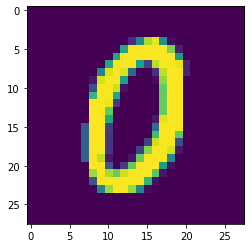

In [54]:
plt.imshow(test_sample)

In [55]:
from lime.wrappers.scikit_image import SegmentationAlgorithm

In [56]:
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [57]:
explanation = explainer.explain_instance(test_x[0], 
                                         classifier_fn = prediction_function, 
                                         top_labels=10, hide_color=0, num_samples=100, segmentation_fn=segmenter)

In [58]:
sample_test_input = test_x[0]
sample_test_input.shape

(28, 28, 3)

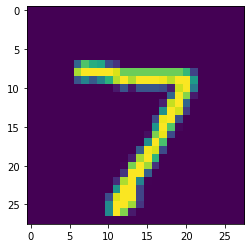

In [59]:
plt.imshow(np.reshape(rgb2gray(sample_test_input),(28,28)))

In [60]:
output = np.argmax(test_y[0])
output

7

Text(0.5, 1.0, 'Positive Regions for 7')

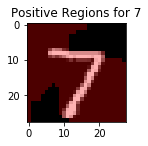

In [61]:
temp, mask = explanation.get_image_and_mask(output, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig= plt.figure()
(ax1) = fig.add_subplot(2,1,1)
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(output))

In [62]:
fig.savefig("sample_input_explanation.jpeg")

Text(0.5, 1.0, 'Positive and Negative Regions for 7')

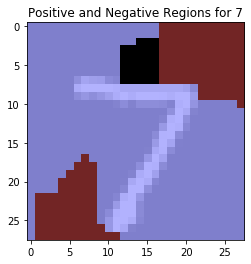

In [63]:
temp1, mask1 = explanation.get_image_and_mask(output, positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
(ax2) = plt.subplot()
ax2.imshow(label2rgb(mask1,temp1, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive and Negative Regions for {}'.format(output))

In [64]:
def add_noise(image):
  row,col,ch = image.shape
  s_vs_p = 0.5
  amount = 0.01
  out = np.copy(image)
  # Salt mode
  num_salt = np.ceil(amount * image.size * s_vs_p)
  coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
  out[coords] = 1

  # Pepper mode
  num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
  coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
  out[coords] = 0
  return out

In [65]:
noisy_input = add_noise(sample_test_input)

C:\Users\Administrator\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Administrator\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  app.launch_new_instance()


In [66]:
noisy_input.shape

(28, 28, 3)

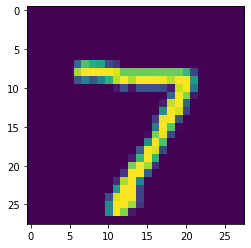

In [67]:
plt.imshow(np.reshape(rgb2gray(noisy_input),(28,28)))

In [68]:
#from skimage.measure import structural_similarity as ssim
from skimage import measure
#import cv2

In [69]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

def compare_images(imageA, imageB, title):
  # compute the mean squared error and structural similarity
  # index for the images
  m = mse(imageA, imageB)
  #s = ssim(imageA, imageB,multichannel=True)
  s = measure.compare_ssim(imageA, imageB,multichannel=True)

  # setup the figure
  fig = plt.figure(title)
  plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))

  # show first image
  ax = fig.add_subplot(1, 2, 1)
  plt.imshow(imageA, cmap = plt.cm.gray)
  plt.axis("off")

  # show the second image
  ax = fig.add_subplot(1, 2, 2)
  plt.imshow(imageB, cmap = plt.cm.gray)
  plt.axis("off")

  # show the images
  plt.show() 
  return m,s

C:\Users\Administrator\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


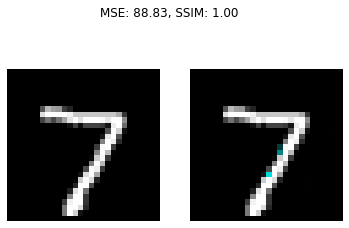

In [70]:
mse1,s1 = compare_images(sample_test_input,noisy_input,"Image Difference")

In [71]:
explanation = explainer.explain_instance(noisy_input, 
                                         classifier_fn = prediction_function, 
                                         top_labels=10, hide_color=0, num_samples=100, segmentation_fn=segmenter)

Text(0.5, 1.0, 'Positive Regions for 7')

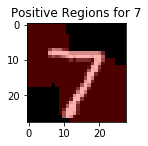

In [72]:
temp, mask = explanation.get_image_and_mask(output, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig= plt.figure()
(ax1) = fig.add_subplot(2,1,1)
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(output))

In [73]:
fig.savefig("noisy_input_explanation.jpeg")

In [74]:
import cv2
img = cv2.imread('noisy_input_explanation.jpeg')

In [75]:
img.shape

(288, 432, 3)

In [76]:
img2 = cv2.imread('sample_input_explanation.jpeg')

In [77]:
img2.shape

(288, 432, 3)

C:\Users\Administrator\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


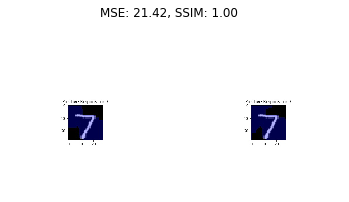

In [78]:
mse2,s2= compare_images(img,img2,"Explanation Difference")

In [79]:
#stability score for the current image
# stability = change in the explanation / change in the input
stability = mse2/mse1

In [80]:
stability

0.24110422425717298

In [81]:
#To find the average stability of the model
#we can run over all the test images